# 4章に該当

In [62]:
%reload_ext autoreload
%autoreload 2 

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from modules.nonparametric_modules import *
from modules.semiparametric_modules import *
from modules.causal_inference_modules import *

import random
import scipy.stats as stats

In [63]:
df = pd.read_csv('carrola_data_ready.csv')
df = df[df.columns[1:]]

3章ではカーネル法を使った回帰ではW＆Bグレードだけを対象に実施した。(説明変数がスカラーなので)  \
ここでも同様にW&Bグレードを対象とするが、説明変数を増やす。

In [64]:
df_X_train = df.iloc[:1000, :].loc[df['W'] == 1][['mil', 'age']].to_numpy()
df_y_train = df.iloc[:1000, :].loc[df['W'] == 1]['price'].to_numpy()
df_X_test = df.iloc[1000:, :].loc[df['W'] == 1][['mil', 'age']].to_numpy()
df_y_test = df.iloc[1000:, :].loc[df['W'] == 1]['price'].to_numpy()

# 4.1 部分線形モデル

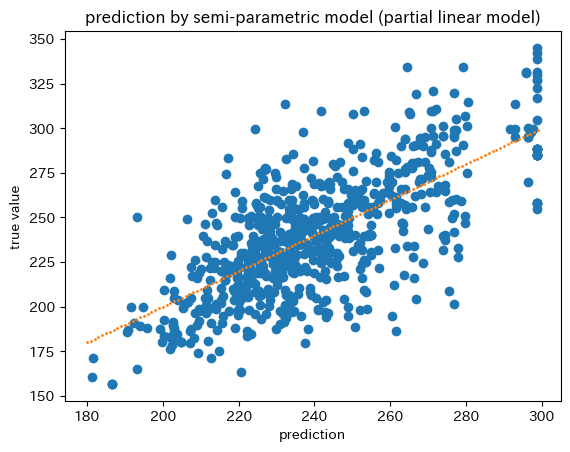

In [65]:
kernel = TriangularKernel()
band_width = 1

X = df_X_train[:, 0]
Z = df_X_train[:, 1]
y = df_y_train

beta = calculate_robinson_estimator(X, y, Z, kernel, band_width)

eta_x_hat = np.array([nadaraya_watson_estimator(
    Z, X, kernel, i, band_width) for i in Z])
eta_y_hat = np.array([nadaraya_watson_estimator(
    Z, y, kernel, i, band_width) for i in Z])

X = (X - eta_x_hat).reshape(-1, 1)
X = np.hstack([np.array([1]*df_X_train.shape[0]).reshape(-1, 1), X])
plt.scatter(X@beta+eta_y_hat, y)
plt.scatter(range(180, 300), range(180, 300), s=1)
plt.xlabel('prediction')
plt.ylabel('true value')
plt.title('prediction by semi-parametric model (partial linear model)')
plt.show()

# 4.2 シングルインデックスモデル

In [66]:
# 市村推定量用には悪いことはいわないから100程度にしておくべき。
train_data_size = 100
df_X_train = df.iloc[:train_data_size, 1:].to_numpy()
df_y_train = df.iloc[:train_data_size, 0].to_numpy()
df_X_test = df.iloc[train_data_size:, 1:].to_numpy()
df_y_test = df.iloc[train_data_size:, 0].to_numpy()

band_width = 1

iteration 1: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 2: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 3: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 4: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 5: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 6: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 7: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 8: x = [0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ]
iteration 9: x = [0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.09, 0.1 , 0.1 , 0.1 ]
iteration 10: x = [0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.09, 0.1 , 0.1 , 0.1 ]
iteration 11: x = [0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.09, 0.1 , 0.1 , 0.1 ]
iteration 12: x = [0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.09, 0.1 , 0.1 , 0.1 ]
iteration 13: x = [0.1 , 0.11, 0.1 , 0.1 , 0.11, 0.09, 0.09, 

/home/takehiro/car_price_analysis/modules/nonparametric_modules.py:162: RuntimeWarning: invalid value encountered in scalar divide
  return (kernel_series*y).sum()/kernel_series.sum()


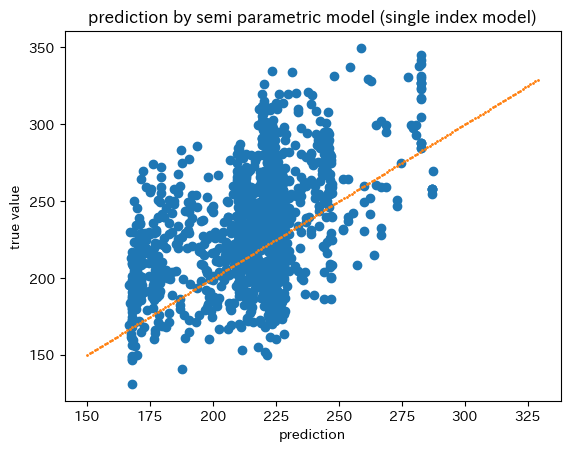

In [67]:
delta_hat = calculate_ichimura_estimator(
    df_X_train, df_y_train, 1, kernel, verbose=True)
beta_hat = np.hstack([np.array([1]), delta_hat])
prediction = []
for i in df_X_test:
    prediction.append(nadaraya_watson_estimator(
        df_X_train@beta_hat, df_y_train, kernel, i@beta_hat, band_width))

plt.scatter(prediction, df_y_test)
plt.scatter(range(150, 330), range(150, 330), s=1)
plt.xlabel('prediction')
plt.ylabel('true value')
plt.title('prediction by semi parametric model (single index model)')
plt.show()

# 4.3 平均処置効果

平均処置効果(ATE)は  
$\tau_{ate} = \mathbb{E}{[Y_i(1) - Y_i(0)]}$  

であり、強い無視可能性が成り立つならば、  

$\tau_{ate} = \mathbb{E}{[\mu_1(X_i) - \mu_0(X_i)]}$  
このとき、  
$\mu_1(X_i) = \mathbb{E}[Y_i|X_i = x, D_i =1]$  
$\mu_0(X_i) = \mathbb{E}[Y_i|X_i = x, D_i =0]$ 

また、以下の傾向スコアと呼ばれる値 \
$p(x) = P(D_i=1|X_i=x)$  
を使って  

$\eta_d :=\mathbb{E}[D_iY_i|X_i=x] = \mathbb{E}[D_iY_i(1)|X_i=x] = p(x)\mu_1(x)$  
$\eta_{1-d} :=\mathbb{E}[(1-D_i)Y_i|X_i=x] = \mathbb{E}[(1-D_i)Y_i(0)|X_i=x] = (1-p(x))\mu_0(x)$

が成り立つため、以下の3つの方法で$\tau_{ate}$が識別できる。

1. $\tau_{ate} = \mathbb{E}{\left[Y_i(1) - Y_i(0)\right]}$ (4.6) 

2. $\tau_{ate} = \mathbb{E}\left[\frac{\eta_d{(X_i)}}{p(X_i)} -\frac{\eta_{1-d}{(X_i)}}{1-p(X_i)}\right] $(4.7) 

3. $\tau_{ate} = \mathbb{E}\left[\frac{D_iY_i}{p(X_i)} -\frac{(1-D_i)Y_i}{1-p(X_i)}\right]$ (4.8) 


In [68]:
# (4.6)方式(4.7)、W&Bグレードに対して介入(修復歴)による価格への影響を回帰調整法で推定してみる。
# なお、それぞれの回帰式は単純な重回帰である。
df_0 = df[(df['rep'] == 0) & (df['W'] == 1)]
df_1 = df[(df['rep'] == 1) & (df['W'] == 1)]

df_y_0 = df_0['price'].to_numpy()
df_X_0 = df_0[['age', 'mil', 'hyb', '4wd']].to_numpy()
df_y_1 = df_1['price'].to_numpy()
df_X_1 = df_1[['age', 'mil', 'hyb', '4wd']].to_numpy()


tau_hat_ate_RA = calculate_ATE_by_regression_adjustment(
    df_X_0, df_y_0, df_X_1, df_y_1)

mean_price_difference = df_0['price'].mean() - df_1['price'].mean()

print(f'事故車の因果推論手法を用いた価格低下分は{-tau_hat_ate_RA:.2f}万円')
print(f'一方、(非事故車の価格平均)-(事故車の価格平均)は{mean_price_difference:.2f}万円')
if -tau_hat_ate_RA > mean_price_difference:
    print('従って単純平均だと過小評価してしまうことがわかる。')
else:
    print('従って単純平均だと過大評価してしまうことがわかる。')

事故車の因果推論手法を用いた価格低下分は41.52万円
一方、(非事故車の価格平均)-(事故車の価格平均)は40.24万円
従って単純平均だと過小評価してしまうことがわかる。


In [69]:
# (4.8)方式、W&Bグレードに対して介入(修復歴)による価格への影響を逆確率重み付け法(IWP)で推定してみる。
# なお、pには単純な線形ロジスティック回帰法を用いた。
from sklearn.linear_model import LogisticRegression


df_W = df[df['W'] == 1][['rep', 'age', 'mil', 'hyb', '4wd']]
df_W_X = df_W[['age', 'mil', 'hyb', '4wd']].copy(deep=True).to_numpy()
df_W_y = df_W['rep'].to_numpy()


df_W_price = df[df['W'] == 1]['price'].to_numpy()
tau_hat_ate_IWP = calculate_ATE_by_IWP(df_W_X, df_W_y, df_W_price)


print(f'事故車の因果推論手法を用いた価格低下分は{-tau_hat_ate_RA:.2f}万円')
print(f'一方、(非事故車の価格平均)-(事故車の価格平均)は{mean_price_difference:.2f}万円')
if -tau_hat_ate_RA > mean_price_difference:
    print('従って単純平均だと過小評価してしまうことがわかる。')
else:
    print('従って単純平均だと過大評価してしまうことがわかる。')

事故車の因果推論手法を用いた価格低下分は41.52万円
一方、(非事故車の価格平均)-(事故車の価格平均)は40.24万円
従って単純平均だと過小評価してしまうことがわかる。


In [70]:
# pをロジスティック回帰で推定したり、価格を線形回帰で推定するのをやめ、それらをノンパラメトリックに推定する。
# p.81の内容。
df_W['price'] = df[df['W'] == 1]['price']
df_W_D = df_W['rep'].to_numpy()
df_W_X = df_W['mil'].to_numpy()


eta_hat_hahn, eta_hat_hirano = calculate_ATE_by_hahn_method(
    df_W_X, df_W_D, df_W['price'].to_numpy())

print(f'{eta_hat_hahn=:.4}')

print(f'{eta_hat_hirano=:.4}')

eta_hat_hahn=-42.51
eta_hat_hirano=-58.62
